# Modeling approaches

The targets for which we're building a predictive model can be described as compositional, where each row of the data matrix consists of 3 proportions that sum to one. Thus, the targets are continuous variables that are bounded by [0,1]. The proportions also have an inherent negative association, since increases in any one of the proportions necessarily means there's a reduction in the others. The modeling approach should ideally account for this association. An additional complexity is that there are a large number of 0s and 1s across the targets, which doesn't play well with many of the models that are useful for proportions/compositional data. 

Thus, modeling choices to make:
1. Model original vs. transformed targets:
  - Original proportions on the [0,1] scale
  - Some transformation that puts $Y$ on a continuous scale
    - Logit transformation
2. Model all three proportions simultaneously, or model each column independently
  - Can model two independently, and subtract from 1 to get third
  - Must use a multivariate model

Modeling approaches:
1. Multivariate (Normal) regression fitted on the observed proportions
2. Multivariate (Normal) regression fitted on the logit-transformed proportions
3. Artificiall neural network fitted on the observed proportions 
4. Zero-one inflated Beta regression fit to each column using Bayesian methods **not done**
5. Zero-one inflated Dirichlet regression using Bayesian methods **not done**

In [479]:
# begin by importing all necessary libraries for this notebook:

import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.special import boxcox

# for fit criteria
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error

# for performing a grid search
from sklearn.model_selection import GridSearchCV

# for CV
from sklearn.model_selection import cross_val_score

# for linear regression
from sklearn import linear_model

# pymc3

import pymc3 as pm

# keras

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from keras import backend
from keras.callbacks import EarlyStopping
from keras.layers import Dropout

# for inline plotting:

%matplotlib inline

In [272]:
# set seed for reproducibility
np.random.seed(12011)

# open clean data

with open("final_adj_armDataChallenge.pickle", "rb") as f:
    X_train_adj,Y_train,X_test_adj,Y_test = pickle.load(f) 

The adjustments necessary for using a logit transformation were inadvertantly performed on the full data set (which included the test set), so recalculating the shifts that are necessary to avoid having true 0s and 1s.

In [476]:
Y_train_prop = Y_train[['xProp','yProp','zProp']]
Y_test_prop = Y_test[['xProp','yProp','zProp']]

# helper function which adjusts cases of 0 or 1

def logit_adjust(var):
    adjust = min(Y_train_prop[var][Y_train_prop[var] > 0]) / 2
    new_var = np.where(Y_train_prop[var] == 0, Y_train_prop[var] + adjust,
        np.where(Y_train_prop[var] == 1, Y_train_prop[var] - adjust, Y_train_prop[var]))
    return new_var

# helper function which transforms proportions to logit scale

def logit(p):
    return np.log(p) - np.log(1 - p)

# create dataframe of Y on the logit scale

Y_train_logit = pd.DataFrame({'xLogit': logit(logit_adjust(var = 'xProp')), 
                              'yLogit': logit(logit_adjust(var = 'yProp')), 
                              'zLogit': logit(logit_adjust(var = 'zProp'))})

Y_train_logit.head()

,xLogit,yLogit,zLogit
0,-0.373208,0.373208,-6.195833
1,-6.200596,-6.310951,5.559187
2,9.935396,-7.153910,-6.195833
3,9.935396,-7.153910,-6.195833
4,-4.456651,4.456651,-6.195833


In [60]:
## little helper function to print results

def display_scores(scores):
    scores_star = [ '%.4f' % elem for elem in scores ]
    print("Mean scores in each fold:", scores_star)
    print("Mean score across folds:", round(scores.mean(),4))
    print("Standard deviation of scores across folds:", round(scores.std(),4))

# Multivariate linear regression

In [ ]:
# prepare regression object

regr = linear_model.LinearRegression()

## On the original (proportion) scale

The average RMSE score across the five folds is 2.8075, which, considering the scale here ranges from [0,1] is very big.

In [205]:
# using 5-fold cross validation

linMRegProp_scores = cross_val_score(estimator=regr, 
                                cv=5, 
                                X=X_train_adj, y=Y_train_prop,
                                scoring='neg_mean_squared_error')

## remember: -MSE, so bigger is *better*
## to convert to RMSE: -sqrt(-MSE)

linMRegLogit_rmse_scores = np.sqrt(-linMRegLogit_scores)

display_scores(linMRegLogit_rmse_scores)

Mean scores in each fold: ['2.8176', '2.7874', '2.8525', '2.7760', '2.8043']
Mean score across folds: 2.8075
Standard deviation of scores across folds: 0.0266


In [202]:
# refit to entire training data

_ = regr.fit(X_train_adj, Y_train_prop)

linMRegProp_preds = _.predict(X_train_adj)

Looking at a scatterplot of observed to predicted proportions, it's clear that this modeling approach has big issues:
1. Since we used a Normal model, predictions exceed the bounds of [0,1]
2. Model predictions are worse in the extreme ends

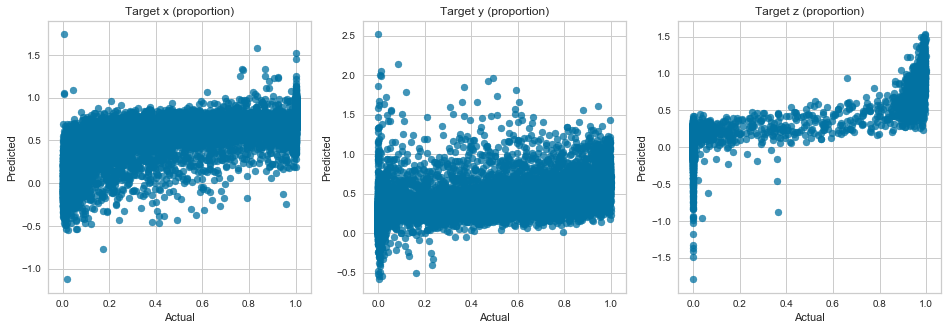

In [104]:
# scatterplot of observed to predicted proportions

plt.figure(figsize=(16,5))

plt.subplot(131)
plt.scatter(Y_train_prop[['xProp']].values,linMRegProp_preds[:,0], alpha=.75, color='b')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Target x (proportion)')

plt.subplot(132)
plt.scatter(Y_train_prop[['yProp']].values,linMRegProp_preds[:,1], alpha=.75, color='b')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Target y (proportion)')

plt.subplot(133)
plt.scatter(Y_train_prop[['zProp']].values,linMRegProp_preds[:,2], alpha=.75, color='b')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Target z (proportion)');

Plotting the predicted values against the residuals $r = y - \hat{y}$, it's clear that the Normal model is not a good one.

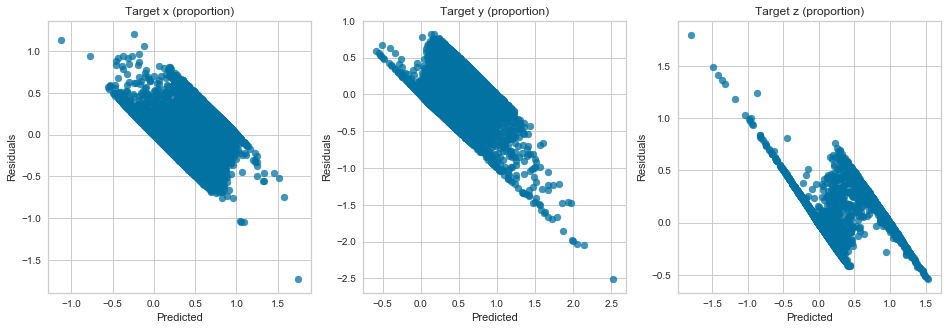

In [207]:
residuals = Y_train_prop[['xProp','yProp','zProp']].values - linMRegProp_preds[:,0:3]

plt.figure(figsize=(16,5))

plt.subplot(131)
plt.scatter(linMRegProp_preds[:,0], residuals[:,0], alpha=.75, color='b')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Target x (proportion)')

plt.subplot(132)
plt.scatter(linMRegProp_preds[:,1], residuals[:,1], alpha=.75, color='b')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Target y (proportion)')

plt.subplot(133)
plt.scatter(linMRegProp_preds[:,2], residuals[:,2], alpha=.75, color='b')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Target z (proportion)');

## On the logit scale

In [154]:
# using 5-fold cross validation

linMRegLogit_scores = cross_val_score(estimator=regr, 
                                cv=5, 
                                X=X_train_adj, y=Y_train_logit,
                                scoring='neg_mean_squared_error')

In [155]:
## remember: -MSE, so bigger is *better*
## to convert to RMSE: -sqrt(-MSE)

linMRegLogit_rmse_scores = np.sqrt(-linMRegLogit_scores)

display_scores(linMRegLogit_rmse_scores)

Mean scores in each fold: ['2.8176', '2.7874', '2.8525', '2.7760', '2.8043']
Mean score across folds: 2.8075
Standard deviation of scores across folds: 0.0266


In [177]:
def inv_logit(x):
    return np.exp(x) / (1 + np.exp(x))

In [181]:
_ = regr.fit(X_train_adj, Y_train_logit)

linMRegLogit_preds = _.predict(X_train_adj)

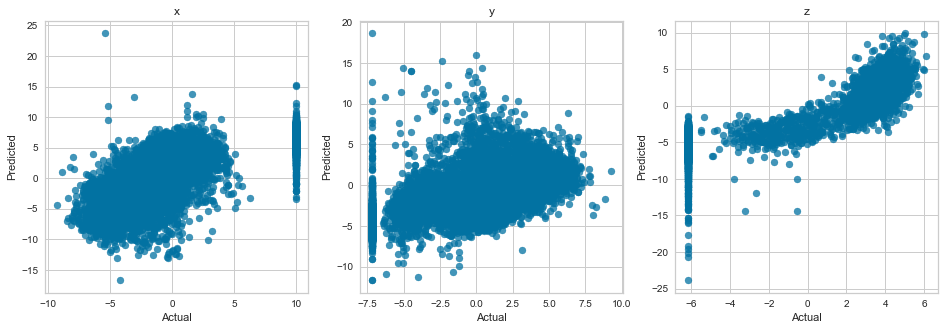

In [183]:
plt.figure(figsize=(16,5))

plt.subplot(131)
plt.scatter(Y_train_logit[['xLogit']].values,linMRegLogit_preds[:,0], alpha=.75, color='b')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('x')

plt.subplot(132)
plt.scatter(Y_train_logit[['yLogit']].values,linMRegLogit_preds[:,1], alpha=.75, color='b')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('y')

plt.subplot(133)
plt.scatter(Y_train_logit[['zLogit']].values,linMRegLogit_preds[:,2], alpha=.75, color='b')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('z');

# Artificial neural network

I'll start by fitting a fully connected neural network to the raw proportion data using Keras. Given the small number of features, and relatively large number of samples in the data, I don't anticipate a very complicated architecture (1-2 hidden layers, with fewer than ~15 neurons in each). Using 5-fold cross validation (see below), 2 hidden layers, each with sigmoid activation functions consisting of 10 and 8 neurons, respectively, was shown to be an adequate architecture. The validation curves below reveal that ~20 epochs is optimal.

In [463]:
# create model

# start neural network
model = Sequential()

model.add(Dense(10, input_shape=(20,) ,activation='sigmoid'))
model.add(Dense(8, activation='sigmoid'))

# output layer
model.add(Dense(3, activation='sigmoid'))

In [461]:
# Keras does not include RMSE as a metric so write a function to be able to include

def rmse(y_true, y_pred):
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

# Compile model
model.compile(loss= "mean_squared_error" , optimizer="adam", metrics=[rmse])

# Fit Model
# Start with 300 epochs and use validation_split to assess optimal #

history = model.fit(X_train_adj, Y_train_prop, epochs=300,
             verbose=0, validation_split=0.33)

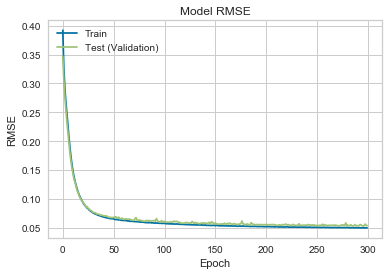

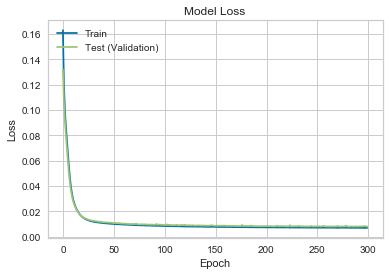

In [462]:
# create validation curves

# summarize history for rmse
plt.plot(history.history['rmse'])
plt.plot(history.history['val_rmse'])
plt.title('Model RMSE')
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test (Validation)'], loc='upper left')
plt.show()

# summarize history for rmse
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test (Validation)'], loc='upper left')
plt.show()

I only include the final CV results for brevity, but I should go back and include these as a function that outputs plots. Here, I use KerasRegressor to implement a sklearn cross validation workflow.

In [464]:
# Function to create model, required for KerasClassifier
def create_model():
    # start neural network
    model = Sequential()
    
    # 2 hidden layers
    model.add(Dense(10, input_shape=(20,) ,activation='sigmoid'))
    model.add(Dense(8, activation='sigmoid'))
    
    # output layer
    model.add(Dense(3, activation='sigmoid'))
    
    # Compile model
    model.compile(loss= "mean_squared_error" , optimizer="adam", metrics=[rmse])
    return model

The average RMSE across the five folds is 0.0142 with a standard deviation of 0.001. As a point estimate, this shows better performance compared to the multivariate regression performed on the proportions/logit transformed data. Looking at scatterplots of observed to predicted values, though, the fit is still problematic, especially in the center of the distribution. This region should be easier! 

In [465]:
# implement 5-fold CV 

model = KerasRegressor(build_fn=create_model, epochs=20, verbose=0)
results = cross_val_score(model, X_train_adj, Y_train_prop, cv=5)

annProp_rmse_scores = -results

display_scores(annProp_rmse_scores)

Mean scores in each fold: ['0.0152', '0.0133', '0.0130', '0.0139', '0.0156']
Mean score across folds: 0.0142
Standard deviation of scores across folds: 0.001


In [466]:
# fit full training data to make predictions

model.fit(X_train_adj, Y_train_prop)
prediction = model.predict(X_train_adj)

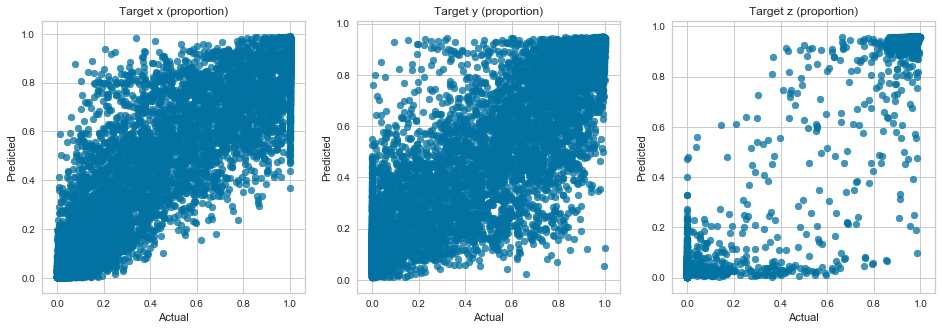

In [467]:
# scatterplot of observed to predicted proportions

plt.figure(figsize=(16,5))

plt.subplot(131)
plt.scatter(Y_train_prop[['xProp']].values,prediction[:,0], alpha=.75, color='b')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Target x (proportion)')

plt.subplot(132)
plt.scatter(Y_train_prop[['yProp']].values,prediction[:,1], alpha=.75, color='b')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Target y (proportion)')

plt.subplot(133)
plt.scatter(Y_train_prop[['zProp']].values,prediction[:,2], alpha=.75, color='b')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Target z (proportion)');

# Test set predictions

Since the ANN showed better performance across the methods here, I'll move forward with assessing the prediction accuracy on the test set.

In [468]:
# Make predictions on the test data
test_preds = model.predict(X_test_adj)

The RMSE evaluating the prediction accuracy on the test set is 0.1213, which is pretty different from the training accuracy established earlier. The ANN was clearly overfitting the data.

In [474]:
# Evaluate the model
rmse = np.sqrt(mean_squared_error(Y_test[['xProp','yProp','zProp']], test_preds))

print('ANN performance on the test set: RMSE = %0.4f' % rmse)

ANN performance on the test set: RMSE = 0.1213


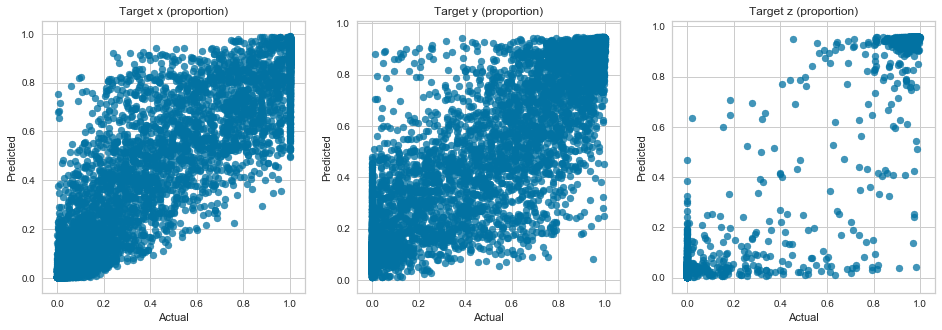

In [478]:
# scatterplot of observed to predicted proportions (test set)

plt.figure(figsize=(16,5))

plt.subplot(131)
plt.scatter(Y_test_prop[['xProp']].values,test_preds[:,0], alpha=.75, color='b')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Target x (proportion)')

plt.subplot(132)
plt.scatter(Y_test_prop[['yProp']].values,test_preds[:,1], alpha=.75, color='b')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Target y (proportion)')

plt.subplot(133)
plt.scatter(Y_test_prop[['zProp']].values,test_preds[:,2], alpha=.75, color='b')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Target z (proportion)');